# Mod3 Project
## Analysis of Bank Telemarketing and Decision Support
### *By Zhi Chen and Daniel Mocombe* 

### <font color=darkblue>Introduction</font>
<font color=darkblue> *Telemarketing is still the main promotion approach in commerical banking industry today. Bank tellers are calling their clients to pursuade them to make term deposit, open money market accounts, loans, etc. Telemarketing promotion is very time-consuming. A bank staff can call a client for more 10 times spending total 3 hours without getting a positive result. A good telemarketing campaign can get good amount of positive response without inputting too much human resources.* </font>

<font color=darkblue> *Therefore, it is essential to understand which type of clients are more likely to response positively to the promotion. And, it is important to establish a model to predict the telemarketing campaign outcome based on the bank's purposes.* </font>

<font color=darkblue> *This notebook is utilizing a Portuguese Bank telemarketing campaign dataset to analyze clients' response to the term deposit promoting.* </font>

### <font color=darkblue>Summary</font>
<font color=darkblue>__*The goals of this Notebook are to: (1) analyze how various features can influence the telemarketing campaign response, help bank tellers to improve telemarketing efficiency; (2) develop machine learning models (with various metrics) that can help bank or bank tellers to predict response of the clients. (3) Based on the results of various models, make suggestions to bank or bank tellers regarding how to use models.*__ </font>

<font color=darkblue> __*This Notebook has 7 parts:*__ </font>

<font color=darkblue> __*1. Data collection and cleaning*__ </font>

<font color=darkblue> __*2. Explanatory Data Analysis, descriptive statistics*__ </font>

<font color=darkblue>__*3. Hypothesis test and analysis*__ </font>

<font color=darkblue>__*4. Preprocessing & feature engineering*__ </font>

<font color=darkblue>__*5. Various model fitting*__ </font>

<font color=darkblue>__*6. Models evaluation*__ </font>

<font color=darkblue>__*7. Business conclusion and discussion*__ </font>

## 1. Data collection and cleaning

### 1.1 Get dataset from kaggle.com, understand all features and target

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns',1000)

In [2]:
df = pd.read_csv('Portuguese Bank.csv', index_col=0)
df.head()

,age,job,marital,education,default,balance,housing,loan,day,month,duration,campaign,pdays,previous,poutcome,response,response_binary
0,58,management,married,tertiary,no,2143,yes,no,5,may,4.35,1,-1,0,unknown,no,0
1,44,technician,single,secondary,no,29,yes,no,5,may,2.52,1,-1,0,unknown,no,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,5,may,1.27,1,-1,0,unknown,no,0
5,35,management,married,tertiary,no,231,yes,no,5,may,2.32,1,-1,0,unknown,no,0
6,28,management,single,tertiary,no,447,yes,yes,5,may,3.62,1,-1,0,unknown,no,0


In [3]:
df1 = pd.read_csv('Portuguese Bank.csv', index_col=0)

The following are explanations of some features in this dataset. 
- default: has credit in default? (categorical: 'no','yes','unknown')
- housing: has housing loan? (categorical: 'no','yes','unknown')
- loan: has personal loan? (categorical: 'no','yes','unknown')
- month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
- day: last contact day of the week
- duration: last contact duration, in seconds
- campaign: number of contacts performed during this campaign and for this client
- pdays: number of days that passed by after the client was last contacted from a previous campaign
- previous: number of contacts performed before this campaign and for this client 
- poutcome: outcome of the previous marketing campaign

### 1.2 Clean up data

In [4]:
# because poutcome represents the outcome of the previous campaign, and more than 85% of this is unknown, there is
# no way we can know what happened last time and it is not appropriate to replace the majority unknown by values
# derived from minority known, so we need to drop this column
df.poutcome.value_counts(normalize = True)

unknown    0.852134
failure    0.113807
success    0.034059
Name: poutcome, dtype: float64

In [5]:
df=df.drop(columns='poutcome')

In [6]:
# the response of the telemarketing campain is binary, so we need to change no(don't make term deposit) and 
# yes(make term deposit) to be 0 and 1
df.response.value_counts()

no     36202
yes     4639
Name: response, dtype: int64

In [7]:
df['binaryresponse'] = np.where(df['response']=='no',0,1)
df.response.value_counts()

no     36202
yes     4639
Name: response, dtype: int64

In [8]:
df=df.drop(columns=['response','response_binary'])

In [9]:
# balance is an important feature of people's bank accounts, let's take a look at this, as we can see below is the
# balance information, generally balance of samples range from -6847 to 10443, but the standard deviation is 1712!
# This std is high, so we are considering replace the extreme values as a part of data-cleaning. 
df.balance.describe()

count    40841.000000
mean      1073.981807
std       1712.556186
min      -6847.000000
25%         64.000000
50%        421.000000
75%       1333.000000
max      10443.000000
Name: balance, dtype: float64

In [10]:
print('lower end of 3 standard deviation:', df['balance'].mean()-3*df['balance'].std(),'\n',
      'upper end of 3 standard deviation:', df['balance'].mean()+3*df['balance'].std())

lower end of 3 standard deviation: -4063.6867508336522 
 upper end of 3 standard deviation: 6211.650365828387


In [11]:
df['balance'] = np.where(df['balance'] < -4064, -4064, df['balance'])
df['balance'] = np.where(df['balance'] > 6212, 6212, df['balance'])

In [12]:
# As we are checking the other features, we do see there are some binary features, like the following 'default', 
# 'housing', 'loan', it is better for us to change these to 0 and 1 to make our dataframe more clean

df['default'] = np.where(df.default == 'no', 0, 1)
df['housing'] = np.where(df.housing == 'no', 0, 1)
df['loan'] = np.where(df.loan == 'no', 0, 1)

In [13]:
# The column pdays mean the number of days that passed by after the client was last contacted from a previous 
# campaign, as we can see there are -1 values in this column, we need to analyze why this happens: 
len(df[df.pdays==-1]), len(df[df.previous==0]), len(df[(df.pdays==-1) & (df.previous==0)])

(34797, 34797, 34797)

In [14]:
# As we can see when there is no previous contacts, pdays is -1, this means that this is the overall first time 
# of contacting this client, so we can change this pdays to be 0
df['pdays'] = np.where(df['pdays'] == -1, 0, df['pdays'])

In [15]:
df.head()

,age,job,marital,education,default,balance,housing,loan,day,month,duration,campaign,pdays,previous,binaryresponse
0,58,management,married,tertiary,0,2143,1,0,5,may,4.35,1,0,0,0
1,44,technician,single,secondary,0,29,1,0,5,may,2.52,1,0,0,0
2,33,entrepreneur,married,secondary,0,2,1,1,5,may,1.27,1,0,0,0
5,35,management,married,tertiary,0,231,1,0,5,may,2.32,1,0,0,0
6,28,management,single,tertiary,0,447,1,1,5,may,3.62,1,0,0,0


## 2. Explanatory Data Analysis, descriptive statistics

### 2.1 Analysis and visualization of the target variable

Target Variable: response
0    0.886413
1    0.113587
Name: binaryresponse, dtype: float64


Text(0.5, 0, 'binaryresponse')

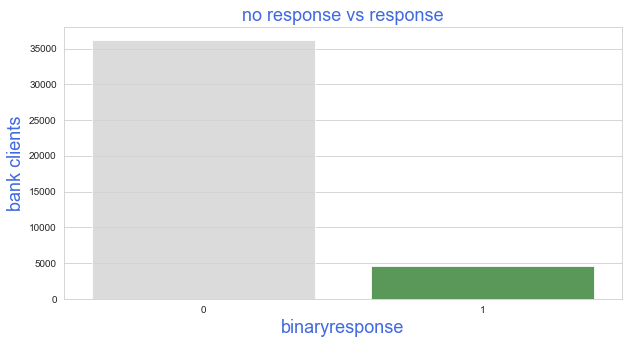

In [16]:
print('Target Variable: response')
print(df.binaryresponse.value_counts(normalize=True))

sns.set_style('whitegrid')
plt.figure(figsize=(10,5))
sns.countplot(df.binaryresponse, alpha=0.8, palette=['lightgrey','forestgreen'])
plt.title('no response vs response', fontsize=18, color='royalblue')
plt.ylabel('bank clients', fontsize=18, color = 'royalblue')
plt.xlabel('binaryresponse', fontsize=18, color = 'royalblue')

__As we can see from the above plot (no response vs response), the clients who responsed only consist 11.36% of the total bank clients. The above plot is very consistant with bank telemarketing business, when commercial bank staff make phone calls to clients to promote the term deposit (CD or money market), only few clients will seriously consider that and finally do that. I am a person who always say that "I am in meeting" when I pick up phone realizing that call is from the bank trying to promote.__

__This is a typical highly imbalanced classification target.__

### 2.2 Can contacts improve the success rate?

In [17]:
df.previous.describe()

count    40841.000000
mean         0.436791
std          1.572342
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         55.000000
Name: previous, dtype: float64

In [18]:
pre_contacts = ['0', '1', '2-5', '6-10', '11-15', 'beyond 15']
pre_rate = [df[df.previous<1].binaryresponse.mean(),
df[df.previous==1].binaryresponse.mean(),
df[(df.previous>1)&(df.previous<=5)].binaryresponse.mean(),
df[(df.previous>5)&(df.previous<=10)].binaryresponse.mean(),
df[(df.previous>10)&(df.previous<=15)].binaryresponse.mean(),
df[df.previous>15].binaryresponse.mean()]
pre_dict = dict(zip(pre_contacts, pre_rate))

Text(0, 0.5, 'positive rate')

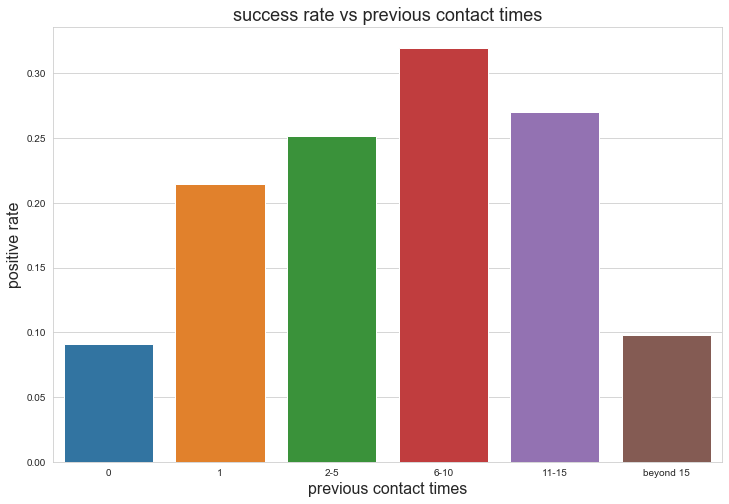

In [19]:
plt.figure(figsize=(12,8))
sns.barplot(x='pre_contacts',y='pre_rate',
            data=pd.DataFrame(pre_dict.items(),columns=['pre_contacts','pre_rate']))
plt.title('success rate vs previous contact times', fontsize=18)
plt.xlabel('previous contact times', fontsize=16)
plt.ylabel('positive rate', fontsize=16)

__Is client more likely to make response if a bank teller calls the client more times? The above plot tell us this. As we can see from this graph, 0 times has the lowest positive response rate, this makes perfect sense because if you didn't contact people before, no relationship established bofore, they are not likely to make positive response. As the number of previous contacts goes up, response rate goes up, but when contacts is beyond 10 times, the response rate goes down. This tells us that if bank teller has called more, clients are more likely to be persuaded to make positive response, but, if bank has previously called too many times, that means this client is not interested at all or getting annoyed by the telephone marketing. If the bank previously called more than 15 times, bank shall consider give up this client and not to waste more time.__

### 2.3 How does different education level affect the target response rate?

In [20]:
df[df.binaryresponse == 0].education.value_counts(normalize=True)

secondary    0.542898
tertiary     0.291890
primary      0.165212
Name: education, dtype: float64

In [21]:
df[df.binaryresponse == 1].education.value_counts(normalize=True)

secondary    0.491270
tertiary     0.390817
primary      0.117913
Name: education, dtype: float64

Text(0.5, 1.0, 'Response')

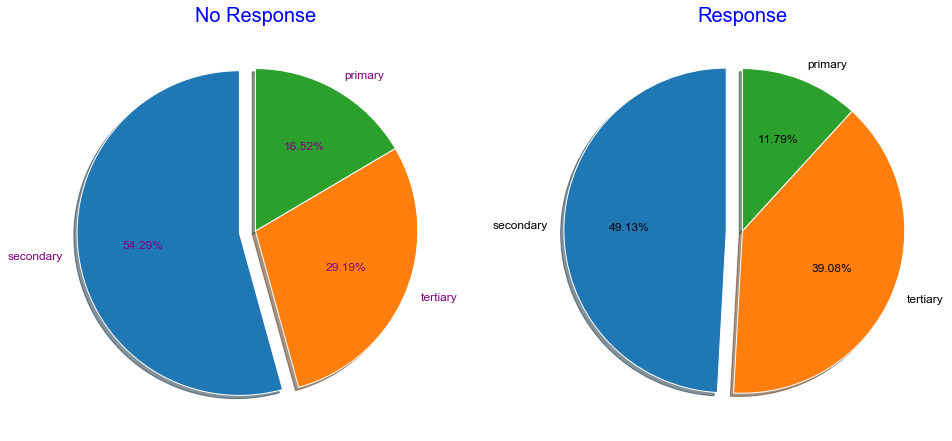

In [22]:
fig=plt.figure(figsize=(16,8))

ax1 = fig.add_subplot(121)
ax1.pie(df[df.binaryresponse==0].education.value_counts().values, 
        labels=df[df.binaryresponse==0].education.value_counts().index, explode=[0.1,0,0],autopct='%1.2f%%',
        shadow=True,startangle=90,textprops={'size':'larger','color':'purple'});
plt.title('No Response', fontsize=20, color = 'blue')

ax2 = fig.add_subplot(122)
ax2.pie(df[df.binaryresponse==1].education.value_counts().values, 
        labels=df[df.binaryresponse==1].education.value_counts().index, explode=[0.1,0,0],autopct='%1.2f%%',
        shadow=True,startangle=90,textprops={'size':'larger','color':'black'});
plt.title('Response', fontsize=20, color = 'blue')

In [123]:
df[df.education=='tertiary'].binaryresponse.mean(), df[df.education=='secondary'].binaryresponse.mean(), df[df.education=='primary'].binaryresponse.mean()

(0.1464458804523425, 0.10390735421510965, 0.08379289215686274)

__Comparing the 2 plots above, we can see there is significant increase in portion of client with high education from no-response to response. Although middle-education-level clients has a large portion(this is because the population of middle-education-level has most population), as it moves from no-response to response, both low-education-level and middle-education-level shrink, and high-education-level clients portion expands. This indicates that banktelemarketing shall focus more on high-education-level clients, shall not focus on clients with least education. (There are 3 education levels for all clients, primary is the lowest refering to before high school; secondary refers to highschool level and tertiary refers to college degrees or post-graduate)__

### 2.4 How different age people response to bank telemarketing

In [23]:
df.age.describe()

count    40841.000000
mean        40.790676
std         10.475473
min         18.000000
25%         33.000000
50%         39.000000
75%         48.000000
max         95.000000
Name: age, dtype: float64

Text(0, 0.5, 'success rate')

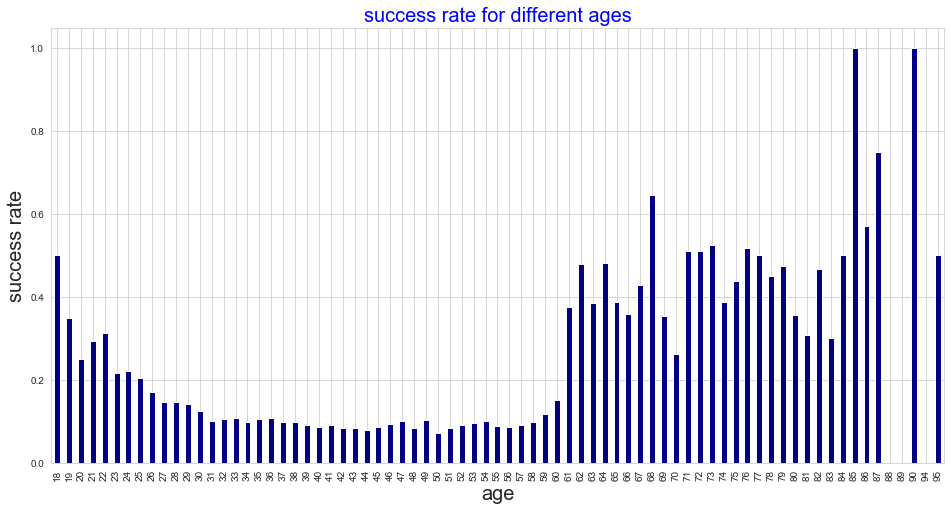

In [24]:
plt.figure(figsize=(16,8))
df.groupby('age').binaryresponse.mean().plot(kind='bar', color='navy')
plt.title('success rate for different ages', fontsize = 20, c='blue')
plt.xlabel('age', fontsize=20)
plt.ylabel('success rate', fontsize=20)

Text(0, 0.5, 'Percentage')

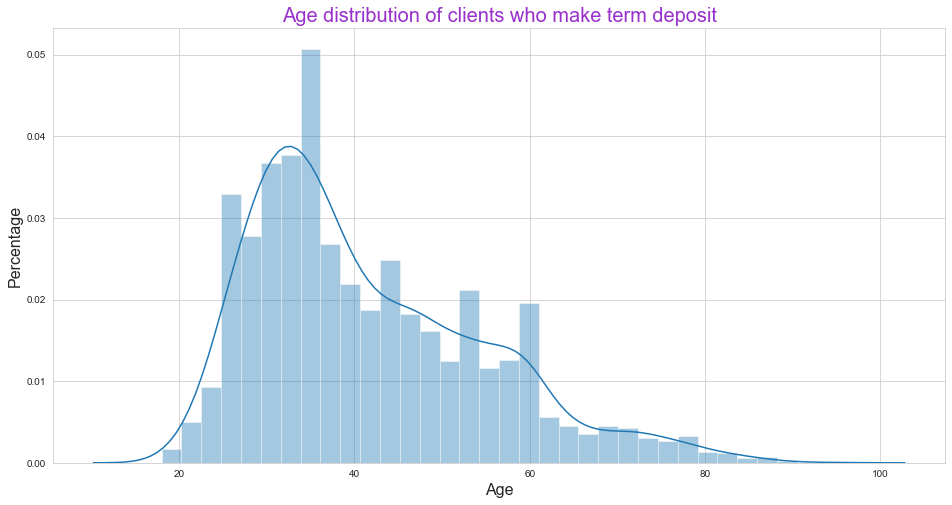

In [25]:
plt.figure(figsize=(16,8))
sns.set_style('whitegrid')
sns.distplot(df[df.binaryresponse==1].age, norm_hist=True)
plt.title('Age distribution of clients who make term deposit', fontsize=20, c='darkorchid')
plt.xlabel('Age', fontsize=16)
plt.ylabel('Percentage', fontsize=16)

Text(0, 0.5, 'Percentage')

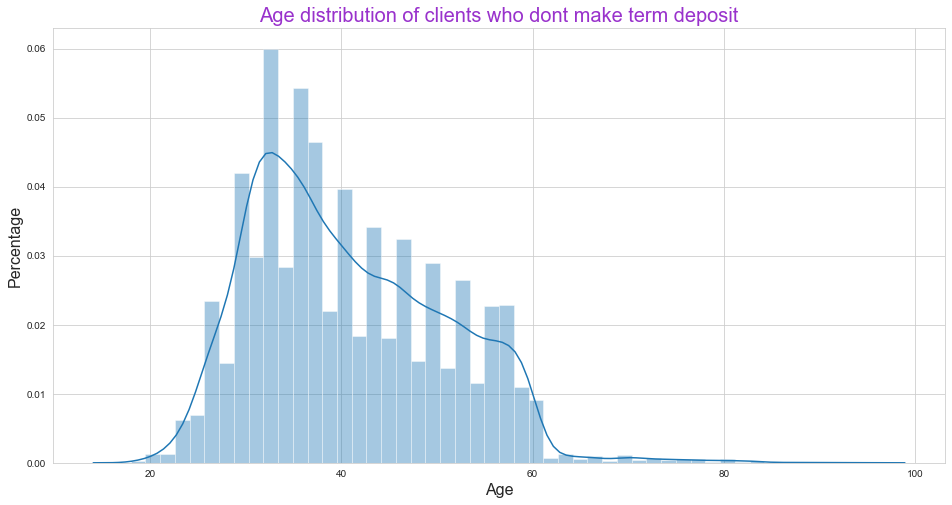

In [26]:
plt.figure(figsize=(16,8))
sns.set_style('whitegrid')
sns.distplot(df[df.binaryresponse==0].age, norm_hist=True)
plt.title('Age distribution of clients who dont make term deposit', fontsize=20, c='darkorchid')
plt.xlabel('Age', fontsize=16)
plt.ylabel('Percentage', fontsize=16)

__There are 3 graphes above, first one is response rate with different ages, the second and third are the age distribution of client who make the term deposit and who don't. We can see that middle age people consist consist the majority of both who make the term deposit and who don't. This is because that the majority bank account owners are middle age people(between 24 to 60). Interestingly, middle age people has least positive response rate, clients with age between 31 to 59 has the least response rate. This means although there are more accounts with middle age clients, telemarketing success rate is low__

### 2.5 How are the likelihood of people with different jobs to give positive response?

In [27]:
df.groupby('job').binaryresponse.mean().sort_values()

job
blue-collar      0.072345
entrepreneur     0.081343
services         0.087345
housemaid        0.087903
other            0.094937
technician       0.108427
self-employed    0.112266
admin.           0.119660
management       0.131349
unemployed       0.156766
retired          0.221782
student          0.294630
Name: binaryresponse, dtype: float64

Text(0.5, 1.0, 'Response Proportion for various job types')

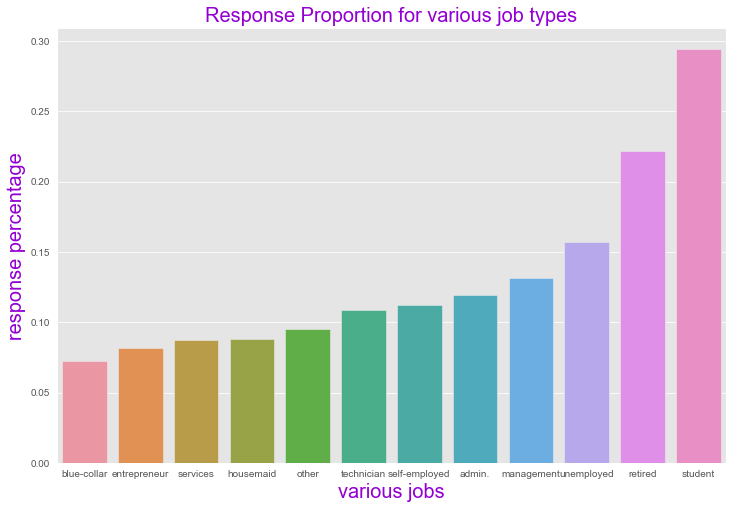

In [85]:
plt.figure(figsize=(12,8))
ax = sns.barplot(x=df.groupby('job').binaryresponse.mean().sort_values().index,
                 y=df.groupby('job').binaryresponse.mean().sort_values().values)
plt.xlabel('various jobs', fontsize=20, color='darkviolet')
plt.ylabel('response percentage', fontsize=20, color='darkviolet')
plt.title('Response Proportion for various job types', fontsize=20, color='darkviolet')

This graph shows the response rate per job type. The clients that are students or retired both have significantly higher response rates compared to other job types. This trend is due to the notion that term deposits being ideal for those looking for income or financial security. For example a student may want to invest in a term deposit while they are in school until they have start paying tuition after graduation. Conversely, those that are employed are likely to have investments in other resources instead of just term deposits.

### 2.6 People start saving in different periods in a year!

In [129]:
m = {'jan':1, 'feb':2, 'mar':3, 'apr':4, 'may':5, 'jun':6, 'jul':7, 'aug':8, 'sep':9, 'oct':10, 'nov':11, 'dec':12}

In [130]:
df1['month_num'] = df1.month.map(m)

Text(0, 0.5, 'Response Rate')

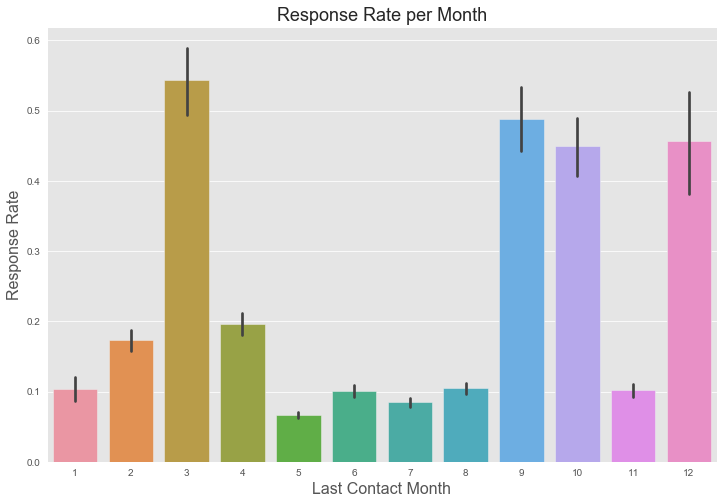

In [134]:
plt.figure(figsize=(12,8))
sns.barplot(x='month_num',y='response_binary',
            data= df1)
plt.title('Response Rate per Month', fontsize=18)
plt.xlabel('Last Contact Month', fontsize=16)
plt.ylabel('Response Rate', fontsize=16)

You can see from this plot that there are certain periods of time people are more likely start to save. (1) At the beginning of a year, after people pay off the credit card on fire after December, March is a point that people start to save. (2) After the summer, more people are likely to start saving for next year. 

## 3. Hypothesis test and analysis

### 3.1 Is there statistically significant difference in account balance with clients in different occupations?
- Ho: There is no statistically significant difference in account balance with clients in different occupations.
- Ha: There is significant difference in account balance with clients in different occupations.

In [29]:
df.job.unique()

array(['management', 'technician', 'entrepreneur', 'retired', 'admin.',
       'services', 'blue-collar', 'self-employed', 'unemployed',
       'housemaid', 'student', 'other'], dtype=object)

In [30]:
from scipy import stats
stats.f_oneway(df['balance'][df['job'] == 'management'],
                df['balance'][df['job'] == 'technician'],
                df['balance'][df['job'] == 'entrepreneur'],
                df['balance'][df['job'] == 'retired'],
                df['balance'][df['job'] == 'admin.'],
                df['balance'][df['job'] == 'services'],
                df['balance'][df['job'] == 'blue-collar'],
                df['balance'][df['job'] == 'self-employed'],
                df['balance'][df['job'] == 'unemployed'],
                df['balance'][df['job'] == 'housemaid'],
                df['balance'][df['job'] == 'student'],
                df['balance'][df['job'] == 'other'])

F_onewayResult(statistic=39.01178577434871, pvalue=1.159117185537788e-84)

__Conclusion:__ We can see that test statistic and P value are in rejection region. So Null hypothesis can be rejected, we can conclude that there is statistically significant difference in account balance with clients in different occupations. This hypothesis test result is consistent with previous visualization 2.5 in Explanatory Data Analysis. 
__This fact is generally true in US, we can see this is also true in Portugal.__

### 3.2 Will different marital status affect clients' decision to make term deposit?

- Ho: There is no association or relationship between clients' marital status and their willingness to make term deposit,
- Ha: There is association or relationship between clients' marital status and clients' willingness to make term deposit.

In [31]:
df.marital.value_counts()

married     24641
single      11443
divorced     4757
Name: marital, dtype: int64

In [32]:
from scipy.stats import chi2_contingency
table=[[df[df['binaryresponse'] == 0]['marital'].value_counts()],
       [df[df['binaryresponse'] == 1]['marital'].value_counts()]]
stat_m, p_m, dof_m, expected_m = chi2_contingency(table)
print('stat_m=%.3f, p_m=%.3f' % (stat_m, p_m))
if p_m > 0.05:
    print('Probably independent')
else:
    print('Probably dependent')
print(table)

stat_m=181.859, p_m=0.000
Probably dependent
[[married     22228
single       9769
divorced     4205
Name: marital, dtype: int64], [married     2413
single      1674
divorced     552
Name: marital, dtype: int64]]


__Conclusion:__ We can see that test statistic and P value are in rejection region. So Null hypothesis can be rejected, we can conclude that there is association between the distributions of clients' marital status and their willingness to make term deposit. 
__This hypothesis result make sense because married people are definitely different in money saving behavior than people not in marriage.__

## 4. Preprocessing & feature engineering

### 4.1 'age' feature engineering

__As previously showed in Explanatory Data Analysis section 2.4 plot,__ likelihood of people to response varies with ages. Middle age people has least positive response rate and it is showed that different age groups has different response rate (middle age people from 30 to 59 have almost same level of response rate). Thus, although age is continuous variable, it is better to make the continuous age value to several groups.

Text(0, 0.5, 'response')

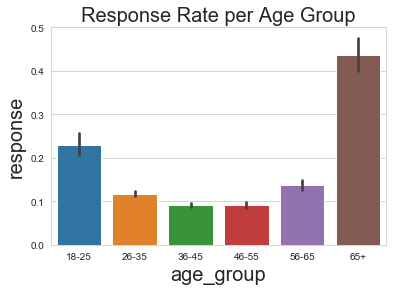

In [33]:
df['age_group'] = pd.cut(df['age'], [17, 25, 35, 45, 55, 65, 100], 
                         labels=['18-25', '26-35', '36-45', '46-55', '56-65', '65+'])
ax = sns.barplot(x='age_group', y=df['binaryresponse'], data=df)
ax.set_title('Response Rate per Age Group', fontsize=20)
plt.xlabel('age_group', fontsize=20)
plt.ylabel('response', fontsize=20)

### 4.2 Contact times feature engineering

For contact times ('previous') feature, we can see from the above __Explanatory Data Analysis section 2.2 plot__ that it does not have continuous influence to the target variable, but different range of previous contact times are likely to give different response result. Thus, it is better to engineer this feature to several group intervals: 0, 1, 2-5, 6-10, 11-15, beyond 15. This make more sense than just using the 'Previous' as continuous variables from 0 all the way to 55.

In [34]:
df['pre_contact'] = pd.cut(df['previous'], [-1,0,1,5,10,15,100],
                          labels=['0','1','2-5','6-10','11-15','beyond 15'])

### 4.3 'month' feature engineering

- When it comes to the month feature, we can see that this is 12 categorical values. After analyzing the following statistics of the different months with different response rate, it is clear that months can be divided into groups with similarity in response rates. Some months have significant high response rate (like 'sep', 'oct' and 'dec' and they are close to each other), while some months have significant lower response rate (like 'jan', 'jun', 'aug' and 'nov', they are all very close around 0.10 response rate). This shall be related to different time period during the year that Portuguese people are more likely to save. 

__So, it makes sense to make this categorical feature to several groups before making dummy variables in next step__

In [35]:
df.groupby('month').binaryresponse.mean()

month
apr    0.196125
aug    0.104475
dec    0.456647
feb    0.172719
jan    0.103128
jul    0.084663
jun    0.100968
mar    0.542998
may    0.066101
nov    0.101637
oct    0.449587
sep    0.487965
Name: binaryresponse, dtype: float64

In [36]:
df['m_group'] = df['month']
df['m_group'] = np.where((df['month']=='may')|(df['month']=='jul'), '5_7', df['m_group'])
df['m_group'] = np.where((df['month']=='jan')|(df['month']=='aug')|(df['month']=='jun')|(df['month']=='nov'),
                            '1_6_8_11', df['m_group'])
df['m_group'] = np.where((df['month']=='feb')|(df['month']=='apr'), '2_4', df['m_group'])
df['m_group'] = np.where((df['month']=='sep')|(df['month']=='oct')|(df['month']=='dec'), '9_10_12', df['m_group'])
df['m_group'] = np.where((df['month']=='mar'), '3', df['m_group'])

### 4.4 'campaign' feature engineering

For the 'campaign' feature, we can see from the following descriptive statistics that the response rate for 1-3 times call is above 0.1, rate decreases to range 0.07-0.09 for 4-11 times call, and decrease further above the 12 times. So we can group the 'campaign' feature to 5 groups: 1-3, 4-11, 12-17, beyond 18 times

In [37]:
print(df.groupby('campaign').binaryresponse.mean().to_dict())

{1: 0.1428299974664302, 2: 0.10790730585529808, 3: 0.10799354057327412, 4: 0.08577599506325208, 5: 0.0784557907845579, 6: 0.0718562874251497, 7: 0.061633281972265024, 8: 0.06134969325153374, 9: 0.052083333333333336, 10: 0.05241935483870968, 11: 0.07777777777777778, 12: 0.027586206896551724, 13: 0.04878048780487805, 14: 0.047619047619047616, 15: 0.04878048780487805, 16: 0.02666666666666667, 17: 0.0625, 18: 0.0, 19: 0.0, 20: 0.02564102564102564, 21: 0.029411764705882353, 22: 0.0, 23: 0.0, 24: 0.05, 25: 0.0, 26: 0.0, 27: 0.0, 28: 0.0, 29: 0.07692307692307693, 30: 0.0, 31: 0.0, 32: 0.1111111111111111, 33: 0.0, 34: 0.0, 35: 0.0, 36: 0.0, 37: 0.0, 38: 0.0, 39: 0.0, 41: 0.0, 43: 0.0, 44: 0.0, 46: 0.0, 50: 0.0, 51: 0.0, 55: 0.0, 58: 0.0}


In [38]:
df['cam_contact'] = pd.cut(df['campaign'], [-1,3,11,17,100],
                          labels=['1-3','4-11','12-17','beyond 18'])

In [39]:
df.head()

,age,job,marital,education,default,balance,housing,loan,day,month,duration,campaign,pdays,previous,binaryresponse,age_group,pre_contact,m_group,cam_contact
0,58,management,married,tertiary,0,2143,1,0,5,may,4.35,1,0,0,0,56-65,0,5_7,1-3
1,44,technician,single,secondary,0,29,1,0,5,may,2.52,1,0,0,0,36-45,0,5_7,1-3
2,33,entrepreneur,married,secondary,0,2,1,1,5,may,1.27,1,0,0,0,26-35,0,5_7,1-3
5,35,management,married,tertiary,0,231,1,0,5,may,2.32,1,0,0,0,26-35,0,5_7,1-3
6,28,management,single,tertiary,0,447,1,1,5,may,3.62,1,0,0,0,26-35,0,5_7,1-3


### 4.5 Make dummy variables:

In [40]:
df2 = pd.get_dummies(df, columns = ['job'], drop_first=True)
df2 = pd.get_dummies(df2, columns = ['marital'], drop_first=True)
df2 = pd.get_dummies(df2, columns = ['education'], drop_first=True)
df2 = pd.get_dummies(df2, columns = ['age_group'], drop_first=True)
df2 = pd.get_dummies(df2, columns = ['m_group'], drop_first=True)
df2 = pd.get_dummies(df2, columns = ['pre_contact'], drop_first=True)
df2 = pd.get_dummies(df2, columns = ['cam_contact'], drop_first=True)

In [41]:
df2.head()

,age,default,balance,housing,loan,day,month,duration,campaign,pdays,previous,binaryresponse,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_other,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,marital_married,marital_single,education_secondary,education_tertiary,age_group_26-35,age_group_36-45,age_group_46-55,age_group_56-65,age_group_65+,m_group_2_4,m_group_3,m_group_5_7,m_group_9_10_12,pre_contact_1,pre_contact_2-5,pre_contact_6-10,pre_contact_11-15,pre_contact_beyond 15,cam_contact_4-11,cam_contact_12-17,cam_contact_beyond 18
0,58,0,2143,1,0,5,may,4.35,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
1,44,0,29,1,0,5,may,2.52,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,33,0,2,1,1,5,may,1.27,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
5,35,0,231,1,0,5,may,2.32,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
6,28,0,447,1,1,5,may,3.62,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [42]:
df2.shape

(40841, 44)

### 4.6 Feature selections

Now we are going to use 2 ways to select important features and to filter out some unimportant features. We use the following 2 methods to do feature selection

#### 4.6.1 Embeded Method
Using Lasso with regularization to introduce additional constraints to lower the complexity for fewer coefficients

In [43]:
target = df2.binaryresponse
features = df2.drop(['binaryresponse','age','month','previous','campaign'], axis=1)

In [44]:
from sklearn.model_selection import train_test_split # to split the data into two parts
X_train_fs, X_test_fs, y_train_fs, y_test_fs = train_test_split(features, target, random_state=22,test_size=0.2)

In [45]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# fit the scaler to the training data
scaler.fit(X_train_fs)
#transform the training data
X_train_fs = pd.DataFrame(data = scaler.transform(X_train_fs), columns = features.columns)
#transform the testing dat
X_test_fs = pd.DataFrame(data = scaler.transform(X_test_fs), columns = features.columns)

In [46]:
## training the model
from sklearn.linear_model import Lasso
from sklearn import metrics 
from sklearn.metrics import accuracy_score, f1_score, recall_score
lasso = Lasso(alpha = 0.01, normalize = False)
lasso = lasso.fit(X_train_fs, y_train_fs)
y_train_pred_fs = lasso.predict(X_train_fs)
# y_test_pred_fs = lasso.predict(X_test_fs)

In [47]:
lasso.coef_

array([-0.        ,  0.00102523, -0.02449849, -0.00350372, -0.        ,
        0.11635663,  0.        , -0.00095822, -0.        , -0.        ,
        0.        , -0.        ,  0.        , -0.        , -0.        ,
        0.00634425, -0.        ,  0.        , -0.00056394,  0.00422575,
       -0.        ,  0.00278191,  0.        , -0.        , -0.        ,
        0.        ,  0.01250502,  0.01233102,  0.02804885, -0.00289   ,
        0.04073574,  0.01216356,  0.02237879,  0.01037083,  0.        ,
       -0.        , -0.        , -0.        ,  0.        ])

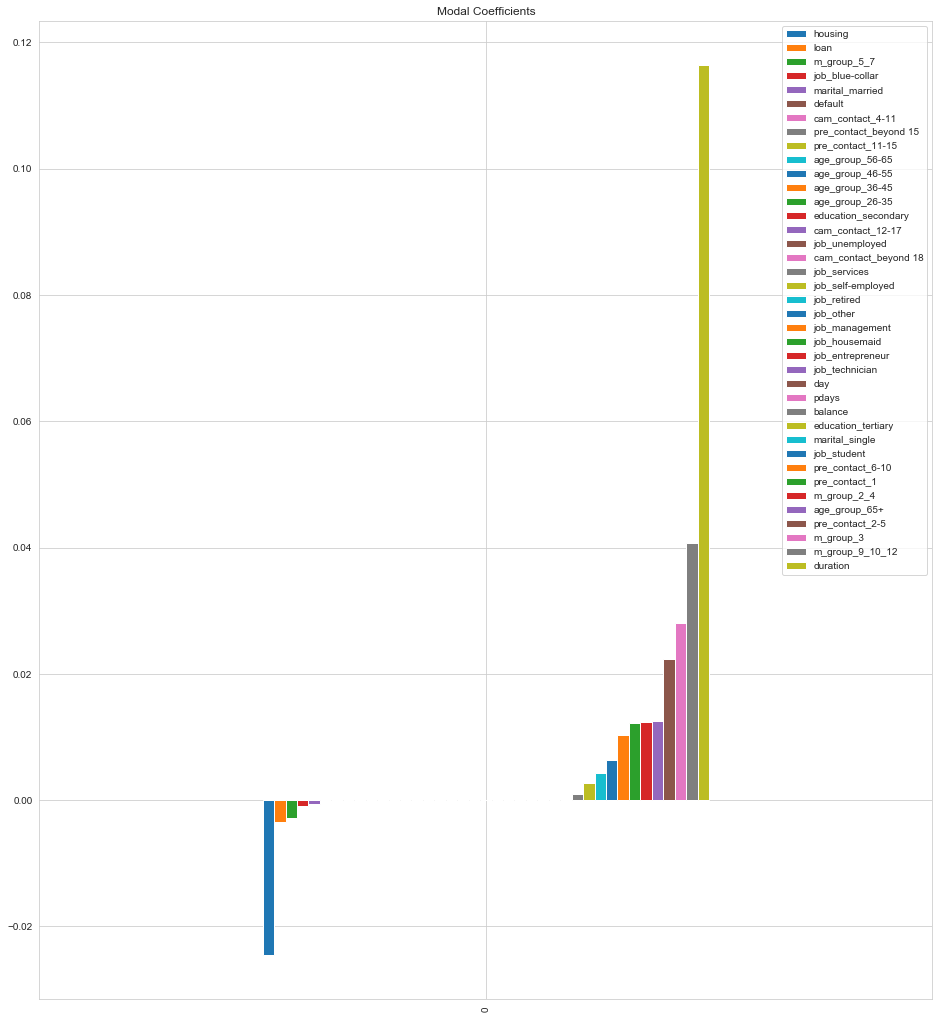

In [48]:
lasso_coef = pd.DataFrame(data=lasso.coef_).T
lasso_coef.columns = X_train_fs.columns
lasso_coef = lasso_coef.T.sort_values(by=0).T
lasso_coef.plot(kind='bar', title='Modal Coefficients', legend=True, figsize=(16,18))

In [49]:
lasso_coef.T

,0
housing,-0.024498
loan,-0.003504
m_group_5_7,-0.002890
job_blue-collar,-0.000958
marital_married,-0.000564
default,-0.000000
cam_contact_4-11,-0.000000
pre_contact_beyond 15,-0.000000
pre_contact_11-15,0.000000
age_group_56-65,0.000000


#### 4.6.2 Use logistic regression with L1 penalty to lower the complexity for fewer coefficients

As we can see the above lasso coefficient, their are more than half of coefficients are 0, some of the features are still important, it may not be a good to filter out these features. Let us use another way to do feature selection and filtering. 

In [50]:
target_lo = df2.binaryresponse
features_lo = df2.drop(['binaryresponse','age','month','previous','campaign'], axis=1)

In [51]:
from sklearn.model_selection import train_test_split # to split the data into two parts
X_train_lo, X_test_lo, y_train_lo, y_test_lo = train_test_split(features_lo, target_lo, random_state=20,test_size=0.2)

In [52]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# fit the scaler to the training data
scaler.fit(X_train_lo)
#transform the training data
X_train_lo = pd.DataFrame(data = scaler.transform(X_train_lo), columns = features_lo.columns)
#transform the testing dat
X_test_lo = pd.DataFrame(data = scaler.transform(X_test_lo), columns = features_lo.columns)

In [53]:
## training the model
from sklearn.linear_model import LogisticRegression
lo = LogisticRegression(penalty='l1', C=0.01, random_state=1, class_weight='balanced')
lo = lo.fit(X_train_lo, y_train_lo)
y_train_pred_lo = lo.predict(X_train_lo)

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [54]:
lo.coef_

array([[ 0.        ,  0.09005071, -0.44974692, -0.17727922, -0.07374684,
         1.42725846, -0.04538699, -0.05793005, -0.02792167, -0.03294223,
         0.        , -0.04625806,  0.        , -0.00462781, -0.00770641,
         0.09849552,  0.        ,  0.        , -0.09947018,  0.01283639,
         0.08198072,  0.19627432, -0.02796414, -0.12042592, -0.10892842,
         0.        ,  0.11742198,  0.2337571 ,  0.26054101, -0.13522277,
         0.32289123,  0.2497011 ,  0.38245313,  0.19894189,  0.05503913,
         0.        , -0.12592874, -0.0476388 , -0.04586597]])

As shown here, when using logistic regression L1 penalty, there are 7 features not contributing, so we can drop these 7 features, this can be a better option than lasso regularization method

In [55]:
features_lo.columns[lo.coef_[0]==0]

Index(['default', 'job_management', 'job_retired', 'job_technician',
       'job_unemployed', 'age_group_56-65', 'pre_contact_beyond 15'],
      dtype='object')

### 4.7 Feature selections summary and analysis

#### Why we are dopping these features? Let's look into it and analyze some features here!

4.7.1 We can clearly see that all the features on dropping list of logistic method are also on dropping list of lasso method. Lasso method dropping list are more than logistic method.

4.7.2 As we can see from above, 'Pdays' is a feature on the edge of dropping in lasso regulation, but it is kept in logistic regression with L1 penalty. The coefficient of 'Pdays' is negative. It makes sense to keep this feature, because it represents number of days that passed by after the client was last contacted from the previous promotion. This feature shall contribute because if a person is previously contacted, this person is more likely to be familar with the bank promotion benefits or more likely to have existing relationship with bank tellers. The larger this value is, the less the person has impression about the bank promotion. 

4.7.3 Another difference of these 2 features selection is 'age_group', as we can see the lasso regulation dropping list has mojority of 'age_group' dummies, but logistic L1 method keeps some of the 'age_group' dummies. From the __'age' feature engineering above__ we can see that different age groups do have siginificant behaviors in response to telemarketing. So it make sense to keep some of the dummy variables in 'age_group' dummies. 

4.7.4 We carefully into other featues in the 2 dropping lists, don't need to explain every one here. For the above reasons, we choose the second feature dropping list. 

## 5. Various model fitting

In [57]:
# import all necessary model fitting tools
from statsmodels.stats.multicomp import pairwise_tukeyhsd, MultiComparison
import itertools
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, make_scorer, confusion_matrix
from imblearn.over_sampling import SMOTE
from collections import Counter
from imblearn.under_sampling import TomekLinks
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, KFold
plt.style.use('ggplot') # nice plots
from sklearn.feature_selection import RFE, SelectFromModel
from sklearn.pipeline import Pipeline 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier #KNN
from sklearn.ensemble import ExtraTreesClassifier
import warnings
from sklearn.utils import resample
%matplotlib inline 

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [58]:
# set up features for the new selected features from the above feature selection
target = df2.binaryresponse
features = df2.drop(['binaryresponse','age','month','previous','campaign','default','job_management','job_retired',
                     'job_technician','job_unemployed','age_group_56-65','pre_contact_beyond 15'], axis=1)

### 5.1 Try KNN model with different k values

In [59]:
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=20, test_size=0.2)
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [60]:
knn = KNeighborsClassifier(n_neighbors=8)

In [61]:
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test)
knn_accuracy = accuracy_score(y_test, knn_pred)
knn_f1 = f1_score(y_test, knn_pred)
knn_recall = recall_score(y_test, knn_pred)
knn_precision = precision_score(y_test, knn_pred)
print('knn score: ', ' accuracy: ', knn_accuracy, ' f1: ', knn_f1, ' recall: ', knn_recall, ' precision: ', knn_precision)

knn score:   accuracy:  0.89386705839148  f1:  0.2744769874476988  recall:  0.1771058315334773  precision:  0.6096654275092936


In [62]:
knn = KNeighborsClassifier(n_neighbors=7)

In [63]:
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test)
knn_accuracy = accuracy_score(y_test, knn_pred)
knn_f1 = f1_score(y_test, knn_pred)
knn_recall = recall_score(y_test, knn_pred)
knn_precision = precision_score(y_test, knn_pred)
print('knn score: ', ' accuracy: ', knn_accuracy, ' f1: ', knn_f1, ' recall: ', knn_recall, ' precision: ', knn_precision)

knn score:   accuracy:  0.8974170645121802  f1:  0.3792592592592593  recall:  0.27645788336933047  precision:  0.6037735849056604


### 5.2 Logistic Regression with different parameters

In [105]:
C_param_range = [0.001,0.01,0.1,1]
lr_titles = ['lr_0_001', 'lr_0_01', 'lr_0_1', 'lr_1']
lr_params = dict(zip(lr_titles, C_param_range)) 
lr_models = {}
scores_table = pd.DataFrame(columns = ['C_parameter','Accuracy','F1','Recall','Precision'])
scores_table['C_parameter'] = C_param_range
j = 0
for k , v  in lr_params.items():
    # Create model using different value for c  
    lr = LogisticRegression(penalty = 'l2', C = v, random_state = 1, class_weight='balanced', solver='liblinear')
    #save the model to a dictionary to use later in our voting classifiers
    lr_models[k]= lr
    lr.fit(X_train, y_train)
    # Predict using model
    lr_pred = lr.predict(X_test)
    # Save all scores in table
    scores_table.iloc[j,1] = accuracy_score(y_test, lr_pred)
    scores_table.iloc[j,2] = f1_score(y_test, lr_pred)
    scores_table.iloc[j,3] = recall_score(y_test, lr_pred)
    scores_table.iloc[j,4] = precision_score(y_test, lr_pred)
    j += 1
scores_table

,C_parameter,Accuracy,F1,Recall,Precision
0,0.001,0.824703,0.52075,0.840173,0.377304
1,0.010,0.834864,0.530783,0.823974,0.391483
2,0.100,0.835108,0.531152,0.823974,0.391885
3,1.000,0.834864,0.530456,0.822894,0.391371


In [65]:
confusion_matrix(y_test, lr_pred)

array([[6058, 1185],
       [ 164,  762]])

In [66]:
features.shape

(40841, 32)

### 5.3 Random Forest with different parameters and GridSearch for precision 

In [67]:
rf_params = {'n_estimators': [380, 400, 430, 450],
              'class_weight': [None, 'balanced'],
              'max_depth': [5, 6, 8],
              'max_features': [0.10, 0.15, 'auto']}

In [68]:
#create a grid search object and fit it to the data

rf = RandomForestClassifier(random_state = 1)

In [69]:
grid_rf = GridSearchCV(rf, param_grid=rf_params, cv=7, scoring='precision', verbose =1, n_jobs=-1)
grid_rf.fit(X_train, y_train)

Fitting 7 folds for each of 36 candidates, totalling 252 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done 252 out of 252 | elapsed: 12.4min finished


GridSearchCV(cv=7, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False, random_state=1,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'cla

In [70]:
# examine the best model
# Single best score achieved across all params (min_samples_split)
print(grid_rf.best_score_)
# Dictionary containing the parameters (min_samples_split) used to generate that score
print(grid_rf.best_params_)
# Actual model object fit with those best parameters
# Shows default parameters that we did not specify
print(grid_rf.best_estimator_)
#Identify the best score during fitting with cross-validation

0.7634024147307693
{'class_weight': None, 'max_depth': 6, 'max_features': 0.15, 'n_estimators': 450}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=6, max_features=0.15, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=450,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)


In [71]:
rf_pred = grid_rf.best_estimator_.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_pred)
rf_f1 = f1_score(y_test, rf_pred)
rf_recall = recall_score(y_test, rf_pred)
rf_precision = precision_score(y_test, rf_pred)
print('rf score:','accuracy:',rf_accuracy,'f1:',rf_f1,'recall:',rf_recall,'precision:',rf_precision)

rf score: accuracy: 0.8873791161708899 f1: 0.017094017094017092 recall: 0.008639308855291577 precision: 0.8


In [72]:
confusion_matrix(y_test, rf_pred)

array([[7241,    2],
       [ 918,    8]])

In [115]:
classes = ['No', 'Yes']

In [126]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix, without normalization')
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.ylim([1.5, -.5])

The following is the confusion matrix of this model

Confusion Matrix, without normalization
[[7241    2]
 [ 918    8]]


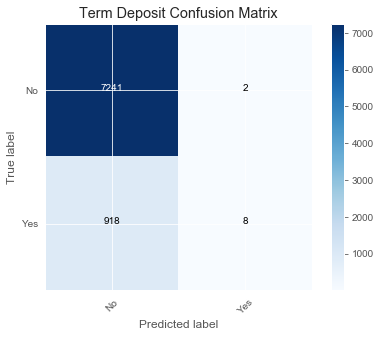

In [135]:
plot_confusion_matrix(metrics.confusion_matrix(y_test, rf_pred), classes, normalize=False, 
                      title='Term Deposit Confusion Matrix', cmap=plt.cm.Blues)

The following is the importances of various features in this model

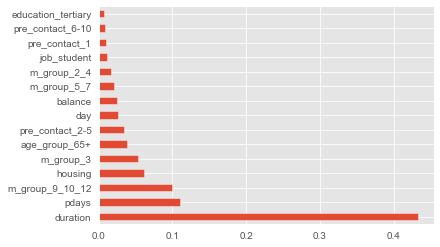

In [109]:
feat_importances = pd.Series(grid_rf.best_estimator_.feature_importances_, index=features.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [153]:
import pickle
filename1 = 'precision.sav'
pickle.dump(grid_rf.best_estimator_, open(filename1, 'wb'))

### 5.4 Random Forest with different parameters and GridSearch for F1

In [73]:
rf_params1 = {'n_estimators': [70, 80, 90],
              'class_weight': ['balanced', None],
              'max_depth': [12, 14, 15],
              'max_features': [0.3, 0.4, 0.5]}

In [74]:
rf = RandomForestClassifier(random_state = 1)

In [75]:
grid_rf1 = GridSearchCV(rf, param_grid=rf_params1, cv=7, scoring='f1',  verbose =1, n_jobs=-1)
grid_rf1.fit(X_train, y_train)

Fitting 7 folds for each of 27 candidates, totalling 189 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 189 out of 189 | elapsed:  5.0min finished


GridSearchCV(cv=7, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False, random_state=1,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'cla

In [76]:
print(grid_rf1.best_score_)
print(grid_rf1.best_params_)
print(grid_rf1.best_estimator_)

0.5755059766809697
{'class_weight': 'balanced', 'max_depth': 14, 'max_features': 0.4, 'n_estimators': 80}
RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=14, max_features=0.4,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=80, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)


In [77]:
rf_pred1 = grid_rf1.best_estimator_.predict(X_test)
rf_accuracy1 = accuracy_score(y_test, rf_pred1)
rf_f11 = f1_score(y_test, rf_pred1)
rf_recall1 = recall_score(y_test, rf_pred1)
rf_precision1 = precision_score(y_test, rf_pred1)
print('rf score:','accuracy:',rf_accuracy1,'f1:',rf_f11,'recall:',rf_recall1,'precision:',rf_precision1)

rf score: accuracy: 0.8866446321459175 f1: 0.5891748003549245 recall: 0.7170626349892009 precision: 0.5


In [78]:
confusion_matrix(y_test, rf_pred1)

array([[6579,  664],
       [ 262,  664]])

### 5.5 GridSearch with RandomForest different parameters for Sensitivity (Recall)

In [79]:
rf_params2 = {'n_estimators': [400, 500, 600],
              'class_weight': ['balanced', None],
              'max_depth': [5, 6, 7],
              'max_features': [0.1, 0.12, 'auto', 0.2]}

In [80]:
rf = RandomForestClassifier(random_state = 1)

In [81]:
grid_rf2 = GridSearchCV(rf, param_grid=rf_params2, cv=7, scoring='recall', verbose =1, n_jobs=-1)
grid_rf2.fit(X_train, y_train)

Fitting 7 folds for each of 36 candidates, totalling 252 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 10.5min
[Parallel(n_jobs=-1)]: Done 252 out of 252 | elapsed: 14.4min finished


GridSearchCV(cv=7, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False, random_state=1,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'cla

In [82]:
print(grid_rf2.best_score_)
print(grid_rf2.best_params_)
print(grid_rf2.best_estimator_)

0.8648005348402031
{'class_weight': 'balanced', 'max_depth': 6, 'max_features': 0.1, 'n_estimators': 400}
RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=6, max_features=0.1,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=400, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)


In [83]:
rf_pred2 = grid_rf2.best_estimator_.predict(X_test)
rf_accuracy2 = accuracy_score(y_test, rf_pred2)
rf_f12 = f1_score(y_test, rf_pred2)
rf_recall2 = recall_score(y_test, rf_pred2)
rf_precision2 = precision_score(y_test, rf_pred2)
print('rf score:', 'accuracy:',rf_accuracy2,'f1:',rf_f12,'recall:',rf_recall2,'precision:',rf_precision2)

rf score: accuracy: 0.8058513893989473 f1: 0.5065339141257 recall: 0.8790496760259179 precision: 0.3557692307692308


In [84]:
confusion_matrix(y_test, rf_pred2)

array([[5769, 1474],
       [ 112,  814]])

The following is the confusion matrix of this model

Confusion Matrix, without normalization
[[5769 1474]
 [ 112  814]]


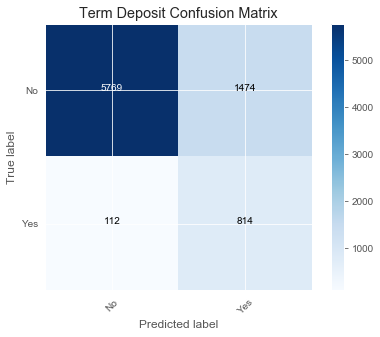

In [128]:
plot_confusion_matrix(metrics.confusion_matrix(y_test, rf_pred2), classes, normalize=False, 
                      title='Term Deposit Confusion Matrix', cmap=plt.cm.Blues)

The following is the importances of variuos features in this model

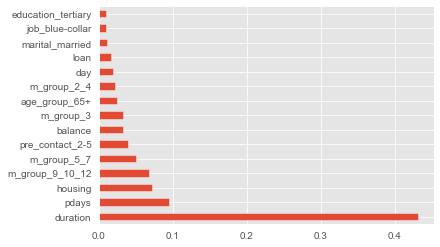

In [110]:
feat_importances = pd.Series(grid_rf2.best_estimator_.feature_importances_, index=features.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [154]:
filename2 = 'sensitivity.sav'
pickle.dump(grid_rf2.best_estimator_, open(filename2, 'wb'))

### 5.6 GridSearchCV with RandomForest for high ROC_AUC

In [97]:
rf_params3 = {'n_estimators': [800, 900, 100],
              'class_weight': [None, 'balanced'],
              'max_depth': [13, 14],
              'max_features': [0.35, 0.4, 0.45]}

In [98]:
rf = RandomForestClassifier(random_state = 1)

In [99]:
grid_rf3 = GridSearchCV(rf, param_grid=rf_params3, cv=7, scoring='roc_auc', verbose =1, n_jobs=-1)
grid_rf3.fit(X_train, y_train)

Fitting 7 folds for each of 18 candidates, totalling 126 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done 126 out of 126 | elapsed: 31.5min finished


GridSearchCV(cv=7, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False, random_state=1,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'cla

In [100]:
print(grid_rf3.best_score_)
print(grid_rf3.best_params_)
print(grid_rf3.best_estimator_)

0.9210994937018743
{'class_weight': None, 'max_depth': 14, 'max_features': 0.35, 'n_estimators': 900}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=14, max_features=0.35, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=900,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)


In [101]:
from sklearn.metrics import roc_auc_score
rf_pred3 = grid_rf3.best_estimator_.predict(X_test)
rf_accuracy3 = accuracy_score(y_test, rf_pred3)
rf_f13 = f1_score(y_test, rf_pred3)
rf_recall3 = recall_score(y_test, rf_pred3)
rf_precision3 = precision_score(y_test, rf_pred3)
rf_roc_auc3 = roc_auc_score(y_test, rf_pred3)
print('rf score:', 'accuracy:',rf_accuracy3,'f1:',rf_f13,'recall:',rf_recall3,'precision:',rf_precision3,
      'roc_auc score:',rf_roc_auc3)

rf score: accuracy: 0.9085567388909291 f1: 0.5202312138728324 recall: 0.4373650107991361 precision: 0.6418383518225039 roc_auc score: 0.7030812352076586


In [106]:
confusion_matrix(y_test, rf_pred3)

array([[7017,  226],
       [ 521,  405]])

## 6. Models evaluation

6.1 __Accuracy is not target:__
This case is very highly imbalance case, the response rate is only around 11%, so high accuracy is not our target in this case. When bank or bank tellers are trying to use telemarketing campaign to get more clients to get into term deposit, there are 2 direction: one is to have high success rate, the other is to get more people.

6.2 __Precision:__ As we analyzed from all previous models, the model that gives best precision score is in section 5.3 ('grid_rf.best_estimator_'), we have the precision 0.80. When we check the confusion matrix, we can see when a positive response is predicted, 80% is correct, in the confusion matrix we can particularly see that for the 10 clients tried, 8 of them finally make term deposit. But this model does miss many of the false negatives (people who are going to make term deposit). 

6.3 __Sensitivity (Recall):__ High sensitivity prevents happenning of false negatives. From the above models, the one with best sensitivity is in section 5.5 ('grid_rf2.best_estimator_'), we have the sensitivity of 0.88. By checking the confusion matrix, we can find out that only very few false negatives exist. But there are lots of  false positives. So if the bank or bank tellers do not want to miss potential clients and does not mind spending more time, more human resources to get more clients, sensitivity is to be emphasized. 

6.4 __Precision and Recall are in tension:__ From all the above models, we found out that we cannot reach to a situation in which we have both high precision and sensitivity. At the best sensitivity scores, precision is not good; at high precision, sensitivity is low. Then we tried to find way to balance, by optimizing the F1 score, we reached to a model has balanced precision and sensitivity. This model in section 5.4 has good performance on various scores.

6.5 __Upsampling and Downsampling gives little further score increase:__ We tried upsampling and downsampling of this imbalanced data, and then use various models to fit again, and had reached a little increase in the precision score and sensitivity score. We are not including the models with upsampling and downsampling here because this notebook is long enough. 

## 7. Business conclusion and discussion

7.1 There are variuous factors that can influence the clients' response to banks' telemarketing. From the analysis in this notebook, we can conclude that: 
- Clients with different ages and occupations do have different response rate to telemarketing, middle age people has the least interests. This is because early age people (students, lack of investment experiences) and old age people (retired people, more conserative) don't have many other choices or willingness to do other investment. The EDA of different occupations responses and different ages responses are very consistent on this point. __So bank tellers shall focus more on these clients so that they can have higher success rate.__
- Education levels matters. Low education level people (people only has primary education experience) are not likely to have positive response to the telemarketing campaign. Among the 3 different education levels, the post-secondary education level (highest) has significance response rate 14%, higher than the middle level(high school education) 10%, and further higher than 8% (lowest level, people only with the primary education). __So bank tellers shall focus more on clients with higher education.__
- There are certain periods of time during a year people start saving. People usually spend more on holiday seasons (like Christmas) and are paying back credit cards after that. You can see March is a peak of people's response to term deposit. Another peak is close to the end of a year, after summer time. __Bank tellers shall start telemarketing campaigns in this periods in order to have good outcome.__

7.2 Some tips to improve bank tellers' telemarketing strategies. 
- __Don't call people too many times__, as shown in Explanatory Data Analysis, when the contact time is beyond 10, the positive response rate decrease, beyond 15 times is the worst. If a client is willing to make term deposit, he/she will do it when bank teller calls him/her certain times. But too many contacts make people feel annoying.
- __Bank balance is not super important__, one may assume that people with high balance in bank accounts are more likely to make term deposit, just because that this person have money to do it. But our analysis of features importances in section 5.3 and 5.5 shows the balance amount is not that important. Balance has some contribution to the final result, but not among the top 5. One thing to remember is that many people bank with more than 1 banking institution. So, low balance in this bank does not mean the person cannot make term deposit. High balance does not mean this person is likely to make term deposit, maybe other banks are offering this person better promotion. 

7.3 How to use the models derived in this project?
- Commercial bank shall consider its marketing activity cost in telemarketing campaign, the cost here is mainly the human resources imput. 
- If the bank has abundant staff and not too busy in this season, it can use the model in section 5.5 with high sensitivity in order not to miss the false negatives. __This way although the precision is not good enough, but the bank gets as many as people truely will make term deposit.__ 
- If the bank has limited human resources, it can use the model in section 5.3 with high precision, __which filters out only limited amount of candidates to be contacted. By doing this, they can get very high success rate. But, this way, bank will loss many false negatives.__
- In our idea, bank who is serious about the telemarketing campaign shall use model in section 5.5 with high sensitivity to get as many clients as possible, because it is not just for term deposit in this campaign, it can also increase __'clients stickiness'. Term deposit is not only to get more deposit, but can also have the clients to stick with this bank for a long time, which can also bring other opportunities to the bank__ 